# Deep Linear Networks

Here, we repeat the experiments by [Jacot et al. (2022)](https://arxiv.org/abs/2106.15933), then [estimate SLT-derived invariants like the learning coefficient](https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py).

Currently, this only looks at the learning task behind figure 3 (not the MC loss behind figure 2).

A **deep linear network** (DLN) of length $L$ is a neural network with $L$ layers of widths $n_0, \dots, n_L$, that computes the transformation:

$$
\begin{align}
f: \mathbb{R}^{n_0} &\to \mathbb{R}^{n_L} \\
x &\mapsto W_L \cdots W_1 x =: A_\theta x,
\end{align}
$$

Parametrized by $\theta \in \mathbb{R}^P$, where $P = \sum_{l=1}^L n_{l-1} n_l$ is the number of parameters.

For convenience, we consider **rectangular networks**, or $(L, w)$-DLNs, with constant hidden width $w$ across all layers: $n_1 = \dots = n_{L-1} = w$.

## Hyperparameters

- $L$ is the number of layers
- $N=n_0$ is the input dimension
- $M=n_L$ is the output dimension
- $r$ is the rank of the "true" matrix / teacher $A^*$
- $w$ or $H$ is the hidden width (for rectangular networks).
- $\sigma$ is the teacher's output noise. By default, we use $\sigma=0$.


# Set-up

- For the definition of the model `DLN`, a `torch.nn.Module`, see `devinterp.zoo.dln.model`.
- For the definition of the dataset `DLNDataset`, a `torch.utils.data.Dataset`, see `devinterp.zoo.dln.dataset`.

## Imports

In [1]:
from typing import Optional, Union, List
import itertools
import logging

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
from typing import Callable, Dict, List, Literal, Optional, Union
from tqdm import tqdm
import functools
import sys
sys.path.append("/home/paperspace/devinterp/")

from devinfra.evals import Criterion
from devinfra.learner import LearnerConfig, Learner
from devinfra.utils.device import get_default_device
from devinfra.utils.tensors import Reduction
from devinfra.evals import CombineEvaluators, Evaluator, RepeatEvaluator
from devinfra.optim.schedulers import LRScheduler
from devinfra.evals import clean_evals_results, MSEEvaluator

from devinterp.slt.sampler import estimate_rlct
from devinterp.optim.sgld import SGLD

from devinterp.zoo.dlns.model import DLN
from devinterp.zoo.dlns.data import DLNDataset

device = get_default_device()
logging.basicConfig(level=logging.INFO)


In [2]:
def sample_single_chain(
    ref_model: nn.Module,
    loader: DataLoader,
    criterion: Callable,
    num_draws=100,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    optimizer_kwargs: Optional[Dict] = None,
    chain: int = 0,
    seed: Optional[int] = None,
    pbar: bool = False,
    device: torch.device = torch.device("cpu"),
):
    # Initialize new model and optimizer for this chain
    model = deepcopy(ref_model).to(device)

    optimizer_kwargs = optimizer_kwargs or {}
    optimizer = SGLD(
        model.parameters(), **optimizer_kwargs
    )  # Replace with your actual optimizer kwargs

    if seed is not None:
        torch.manual_seed(seed)

    num_steps = num_draws * num_steps_bw_draws + num_burnin_steps
    local_draws = pd.DataFrame(index=range(num_draws), columns=["chain", "loss"])

    iterator = zip(range(num_steps), itertools.cycle(loader))

    if pbar:
        iterator = tqdm(iterator, desc=f"Chain {chain}", total=num_steps)

    model.train()

    for i, (xs, ys) in iterator:
        optimizer.zero_grad()
        xs, ys = xs.to(device), ys.to(device)
        y_preds = model(xs)
        loss = criterion(y_preds, ys)
        loss.backward()
        optimizer.step()

        if i >= num_burnin_steps and (i - num_burnin_steps) % num_steps_bw_draws == 0:
            draw_idx = (i - num_burnin_steps) // num_steps_bw_draws
            local_draws.loc[draw_idx, "chain"] = chain
            local_draws.loc[draw_idx, "loss"] = loss.detach().item()

    return local_draws



def _sample_single_chain(kwargs):
    return sample_single_chain(**kwargs)


def sample(
    model: torch.nn.Module,
    loader: DataLoader,
    criterion: torch.nn.Module,
    step: Literal["sgld"],
    optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
    num_draws: int = 100,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    cores: Optional[int] = 1,
    seed: Optional[Union[int, List[int]]] = None,
    pbar: bool = True,
    device: torch.device = torch.device("cpu"),
):
    """
    Sample model weights using a given optimizer, supporting multiple chains.

    Parameters:
        model (torch.nn.Module): The neural network model.
        step (Literal['sgld']): The name of the optimizer to use to step.
        loader (DataLoader): DataLoader for input data.
        criterion (torch.nn.Module): Loss function.
        num_draws (int): Number of samples to draw.
        num_chains (int): Number of chains to run.
        num_burnin_steps (int): Number of burn-in steps before sampling.
        num_steps_bw_draws (int): Number of steps between each draw.
        cores (Optional[int]): Number of cores for parallel execution.
        seed (Optional[Union[int, List[int]]]): Random seed(s) for sampling.
        progressbar (bool): Whether to display a progress bar.
        optimizer_kwargs (Optional[Dict[str, Union[float, Literal['adaptive']]]]): Keyword arguments for the optimizer.
    """
    if cores is None:
        cores = min(4, cpu_count())

    if seed is not None:
        if isinstance(seed, int):
            seeds = [seed + i for i in range(num_chains)]
        elif len(seed) != num_chains:
            raise ValueError("Length of seed list must match number of chains")
        else:
            seeds = seed
    else:
        seeds = [None] * num_chains

    def get_args(i):
        return dict(
            chain=i,
            seed=seeds[i],
            ref_model=model,
            loader=loader,
            criterion=criterion,
            num_draws=num_draws,
            num_burnin_steps=num_burnin_steps,
            num_steps_bw_draws=num_steps_bw_draws,
            step=step,
            optimizer_kwargs=optimizer_kwargs,
            pbar=pbar,
            device=device,
        )

    results = []
    
    if cores > 1:
        if str(device) == "cpu":
            with Pool(cores) as pool:
                results = pool.map(
                    _sample_single_chain, [get_args(i) for i in range(num_chains)]
                )
        else:
            raise NotImplementedError("Cannot currently use multiprocessing with GPU")
    else:
        for i in range(num_chains):
            results.append(_sample_single_chain(get_args(i)))

    results_df = pd.concat(results, ignore_index=True)
    return results_df


def estimate_rlct(
    model: torch.nn.Module,
    loader: DataLoader,
    criterion: Criterion,
    step: Literal["sgld"],
    optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
    num_draws: int = 100,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    cores: Optional[int] = 1,
    seed: Optional[Union[int, List[int]]] = None,
    pbar: bool = True,
    baseline: Literal["init", "min"] = "init",
    device: torch.device = torch.device("cpu"),
) -> float:
    trace = sample(
        model=model,
        loader=loader,
        criterion=criterion,
        step=step,
        optimizer_kwargs=optimizer_kwargs,
        num_draws=num_draws,
        num_chains=num_chains,
        num_burnin_steps=num_burnin_steps,
        num_steps_bw_draws=num_steps_bw_draws,
        cores=cores,
        seed=seed,
        pbar=pbar,
        device=device,
    )

    if baseline == "init":
        baseline_loss = trace.loc[trace["chain"] == 0, "loss"].iloc[0]
    elif baseline == "min":
        baseline_loss = trace["loss"].min()

    avg_loss = trace.groupby("chain")["loss"].mean().mean()
    num_samples = len(loader.dataset)

    return (avg_loss - baseline_loss) * num_samples / np.log(num_samples)


In [3]:
class RectangularDLNConfig(LearnerConfig):
    teacher_matrix: torch.Tensor
    gamma: float = 1.
    w: int = 100
    L: int = 4
    seed: int = 0

    noise_level: float = 1.

    class Config:
        arbitrary_types_allowed=True

    def create_teacher(self):
        return DLN.from_matrix(self.teacher_matrix, L=1)
    
    def create_student(self):
        return DLN.make_rectangular(input_dim=self.input_dim, output_dim=self.output_dim, L=self.L, w=self.w, gamma=self.gamma)
        
    def create_data(self, teacher: DLN):
        return DLNDataset.generate_split(teacher, self.num_training_samples, self.noise_level, self.seed)

    @property
    def input_dim(self):
        return self.teacher_matrix.shape[1]
    
    @property
    def output_dim(self):
        return self.teacher_matrix.shape[0]
    
    def model_dump(self, *args, **kwargs):
        dump = super().model_dump(*args, **kwargs)
        dump["teacher_matrix"] = self.teacher_matrix.tolist()

        return dump    

def make_evals(teacher_matrix: torch.Tensor, trainset: DLNDataset, testset: DLNDataset, device: torch.device):
    teacher_matrix = teacher_matrix.to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    def eval_progress(model: DLN):
        # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
        # This needs a new name.
        singular_values = model.to_matrix().to("cpu").svd().S
        teacher_singular_values = teacher_matrix.to("cpu").svd().S
        missing_singular_values = teacher_singular_values == 0
        teacher_singular_values[missing_singular_values] = 1
        progress = (singular_values / teacher_singular_values)
        # Get rid of division by zero problems
        progress[progress == np.inf] = 0
        progress[progress == -np.inf] = 0
        progress[missing_singular_values] = 0

        return {"progress": torch.sum(progress).item()}
    
    def matrix_evals(model: DLN):
        return clean_evals_results({
            "rank": model.rank(atol=1e-1),
            "ranks": model.ranks(atol=1e-1),
            "grad_norm": model.grad_norm(),
            "nuc_norm": model.norm(p="nuc"),
            "nuc_norms": model.norms(p="nuc")
        })
    
    def eval_rlct(model: DLN):
        model.to("cpu")
        rlct = estimate_rlct(
            model,
            loader=trainloader,
            criterion=F.mse_loss,
            optimizer_kwargs=dict(lr=1e-4, temperature="adaptive", num_samples=len(trainset)),
            num_draws=20,
            num_chains=5,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=1,
            pbar=False,
            baseline="init",
            device=torch.device("cpu")
        )
        model.to(device)
        return {"rlct": rlct}

    return CombineEvaluators([
        MSEEvaluator(train=trainloader, test=testloader, device=device),   
        eval_progress,
        matrix_evals,        
        RepeatEvaluator(eval_rlct, 5)
    ])


def create_dln_learner(config: RectangularDLNConfig):
    teacher = config.create_teacher()
    student = config.create_student()
    trainset, testset = config.create_data(teacher)
    evals = make_evals(teacher_matrix, trainset, testset, config.device)
    learner = Learner(student, trainset, evals, config)
    return learner

NUM_STEPS = 10_000

teacher_matrix = 10. * torch.Tensor(np.diag([1, 2, 3, 4, 5])).detach()
config = RectangularDLNConfig(
    teacher_matrix=teacher_matrix,
    num_training_samples=1024,
    batch_size=128,
    num_steps=NUM_STEPS,
    optimizer_config=dict(
        optimizer_type="SGD",
        lr=1e-3,
        momentum=0.9,
        weight_decay=1e-3,
    ),
    w=100,
    L=4,
    criterion="mse_loss",
    gamma=1.,
    noise_level=0.,
    device=str(device)
)

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
learner = create_dln_learner(config)
learner.train()

{'num_training_samples': 1024, 'batch_size': 128, 'run_name': None, 'num_steps': 10000, 'logger_config': None, 'checkpointer_config': None, 'optimizer_config': OptimizerConfig(optimizer_type='SGD', lr=0.001, weight_decay=0.001, momentum=0.9, betas=None, noise_level=None, elasticity=None, temperature=None, num_samples=None), 'scheduler_config': None, 'device': 'cuda', 'criterion': 'mse_loss', 'teacher_matrix': tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]]), 'gamma': 1.0, 'w': 100, 'L': 4, 'seed': 0, 'noise_level': 0.0}


In [ ]:
df = learner.logger.loggers[0].df
df.sort_values("step", inplace=True)

NameError: name 'learner' is not defined

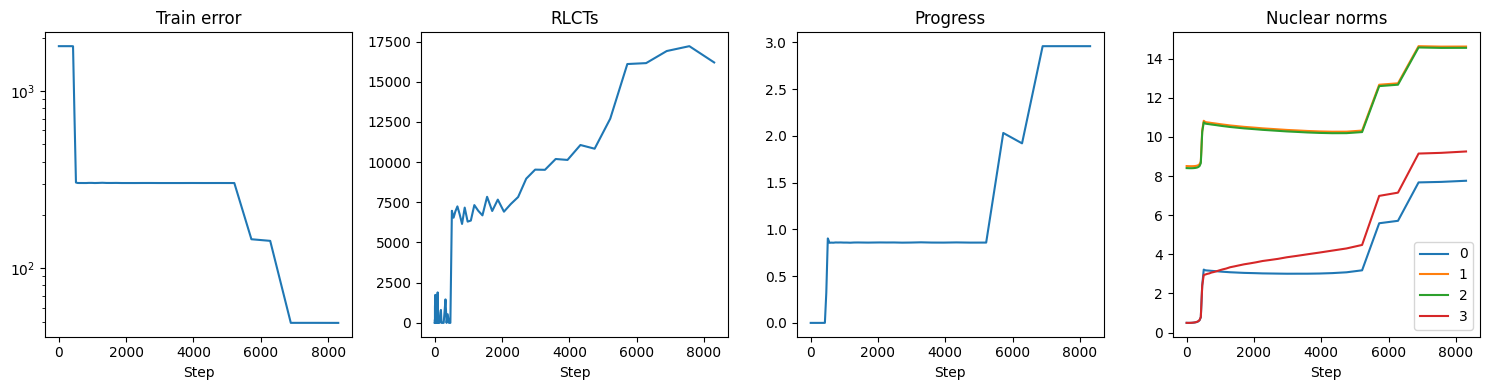

In [ ]:
# Visualizing runs

def plot_all(df, xlog=False, figsize=(15, 4), title=None, smooth_rlcts=0):
    steps = df.step

    fig, axes = plt.subplots(1, 4, figsize=figsize)

    axes[0].set_title("Train error")
    axes[0].plot(steps, df["train/mse"], label="Train")
    axes[0].set_yscale("log")

    # clip to positive values
    rlcts = np.clip(df["rlct/mean"], 0, None)

    # rlcts = sample_run.rlcts
    axes[1].set_title("RLCTs")
    axes[1].plot(steps, rlcts, label="RLCT")
    # axes[1].set_yscale("log")

    axes[2].set_title("Progress")
    axes[2].plot(steps, df["progress"], label="Grad norm")

    # plt.title("Subranks")
    # for l in range(run.L):
    #     plt.plot(np.arange(0, num_steps, 100), [e[l] for e in run.subranks], label=str(l))
    # # plt.yscale("log")
    # plt.legend()
    # plt.show()
    L = 4
    axes[3].set_title("Nuclear norms")
    for i in range(L):
        axes[3].plot(steps, df[f"nuc_norms/{i}"], label=str(i))
    # axes[3].set_yscale("log")
    axes[3].legend()

    for ax in axes:
        ax.set_xlabel("Step")
        if xlog:
            ax.set_xscale("log")

    if title is not None:
        fig.suptitle(title)
    
    plt.tight_layout()
    plt.show()

plot_all(df, xlog=False, smooth_rlcts=100)

# Experiments

In [ ]:
# Defining all the teacher matrices

# Rank 5
rk5_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))
set_seed(0)
rk5_task = Task(rk5_matrix)
set_seed(0)
rk5_err2_task = Task(rk5_matrix, noise_level=10)

# Rank 4
rk4_matrix = rk5_matrix.clone()
rk4_matrix[-1, -1] = 0
set_seed(0)
rk4_task = Task(rk4_matrix)
set_seed(0)
rk4_err2_task = Task(rk4_matrix, noise_level=10)

# Rank 2
rk2_matrix = rk4_matrix.clone()
rk2_matrix[-2, -2] = 0
rk2_matrix[-3, -3] = 0
set_seed(0)
rk2_task = Task(rk2_matrix)
set_seed(0)
rk2_err2_task = Task(rk2_matrix, noise_level=10)

sgld_config = OptimizerConfig(
    optimizer_type="SGLD",
    lr=1e-5,
    noise_level=0.5,
    weight_decay=0.,
    elasticity=1.,
    temperature='adaptive',
    num_samples=100,
)

sampler_config = SamplerConfig(
    optimizer_config=sgld_config,
    num_chains=50,
    num_draws_per_chain=20,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=256,
    criterion='mse_loss'

)

sampler_config.optimizer_config = sgld_config

opt_config = OptimizerConfig(
    optimizer_type="SGD",
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-3,
)

default_kwargs = {"num_steps": 10_000, "gamma": 1.1, "opt_config": opt_config, "sampler_config": sampler_config} # Gamma > 1 puts us slightly in the saddle-to-saddle regime

tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

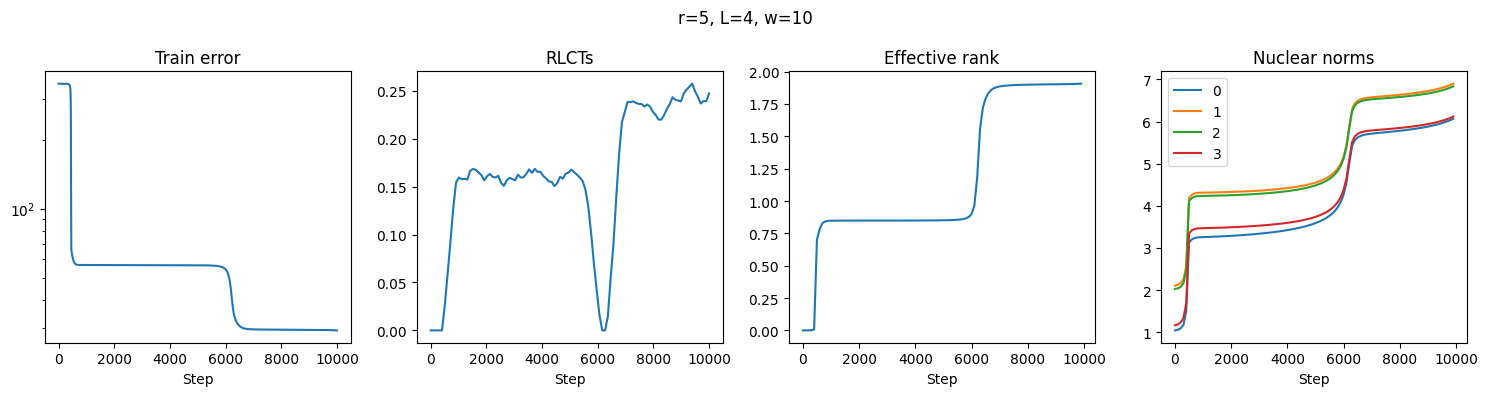

In [ ]:
run_rk5_L4_w10 = fit(rk5_task, w=10, L=4, **default_kwargs)
plot_all(run_rk5_L4_w10, xlog=False, title="r=5, L=4, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

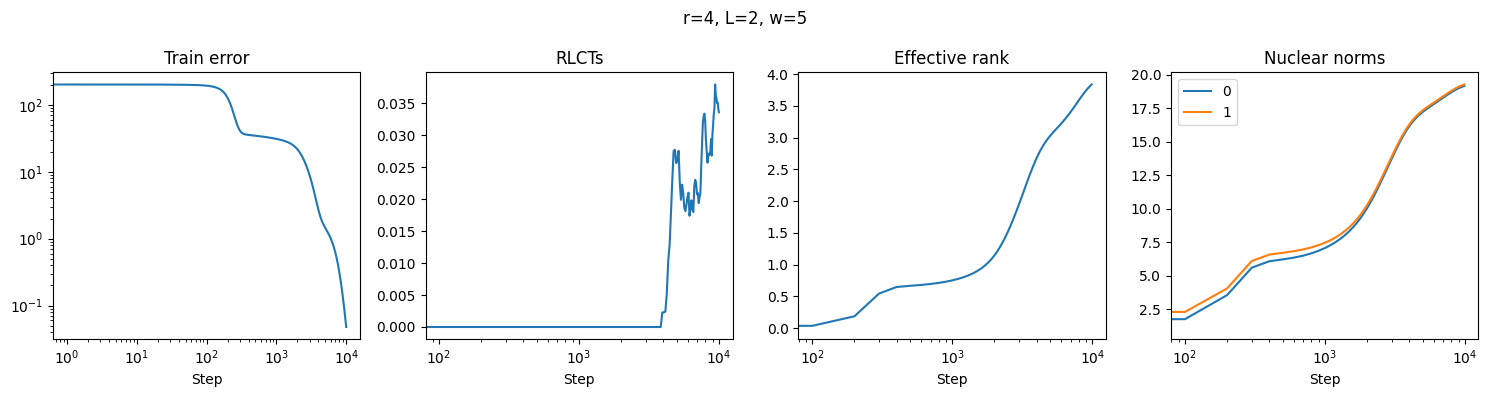

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

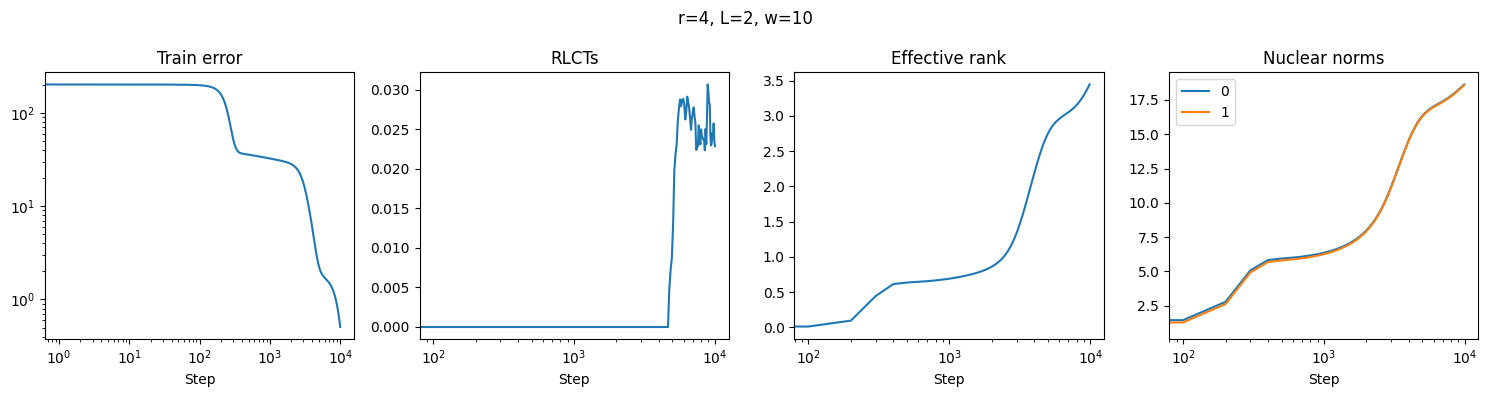

In [ ]:
run_rk4_L2_w5 = fit(rk4_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_L2_w5, xlog=True, title="r=4, L=2, w=5", smooth_rlcts=5)

run_rk4_L2_w10 = fit(rk4_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_L2_w10, xlog=True, title="r=4, L=2, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

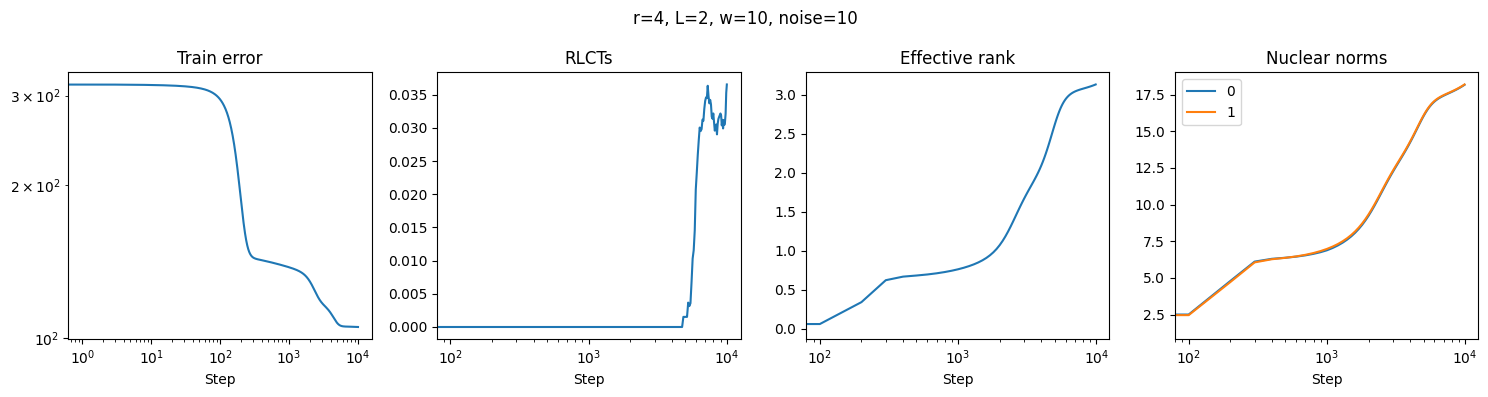

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

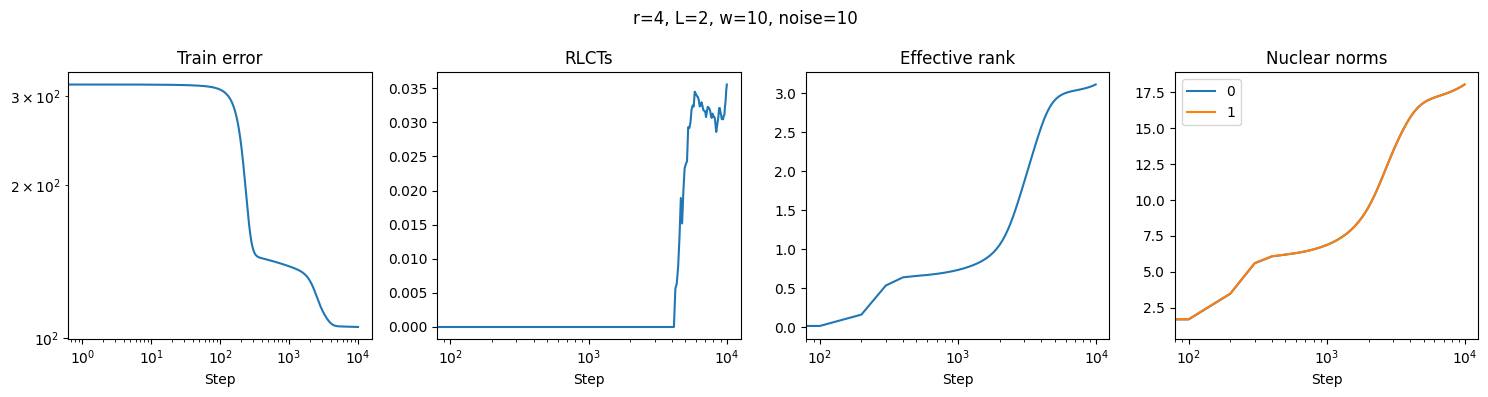

In [ ]:
run_rk4_err2_L2_w5 = fit(rk4_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w5, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

run_rk4_err2_L2_w10 = fit(rk4_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w10, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

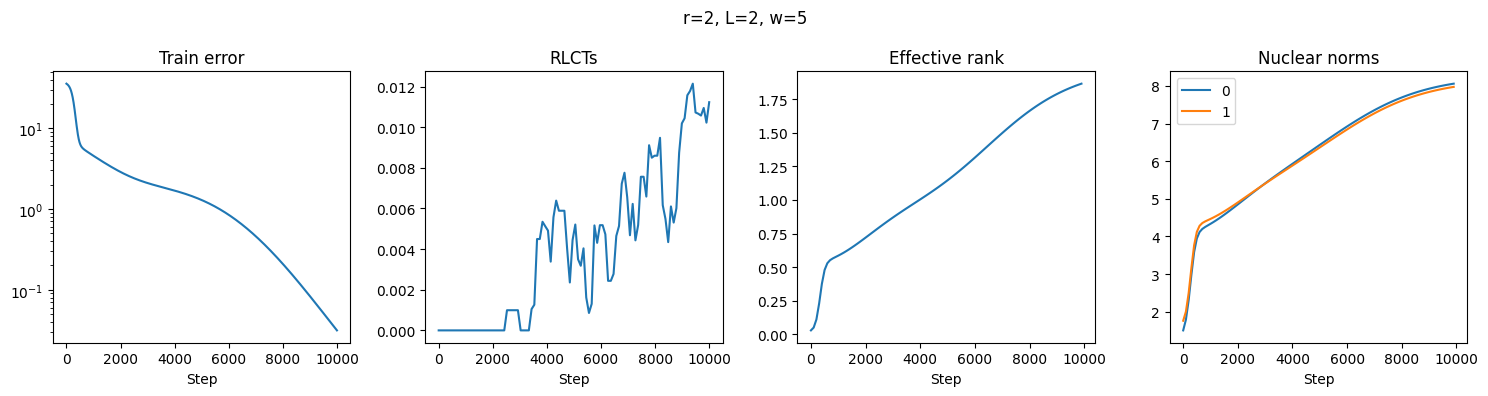

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

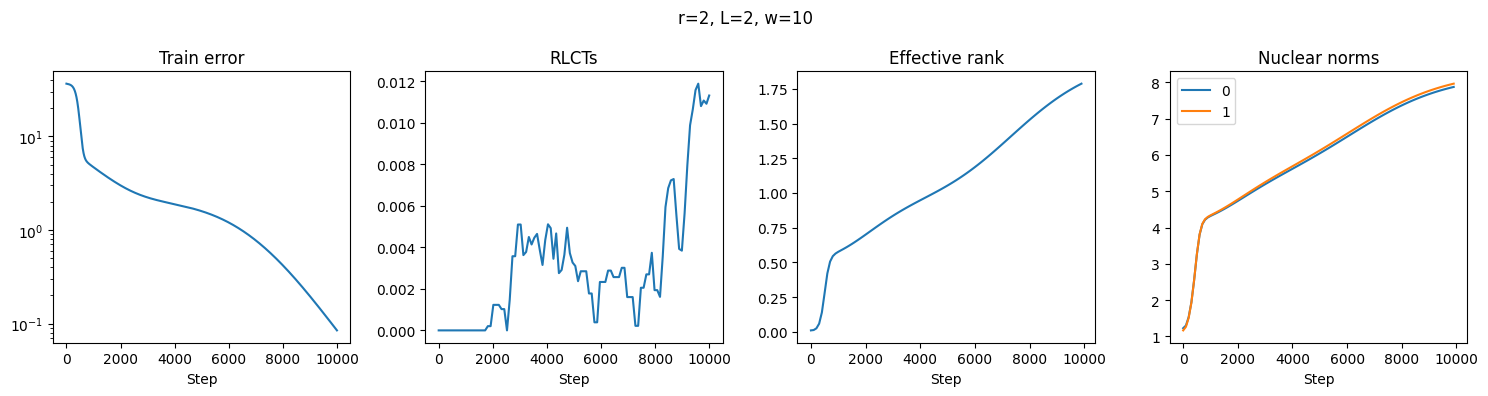

In [ ]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_L2_w5 = fit(rk2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_L2_w5, xlog=False, title="r=2, L=2, w=5", smooth_rlcts=5)

run_rk2_L2_w10 = fit(rk2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_L2_w10, xlog=False, title="r=2, L=2, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

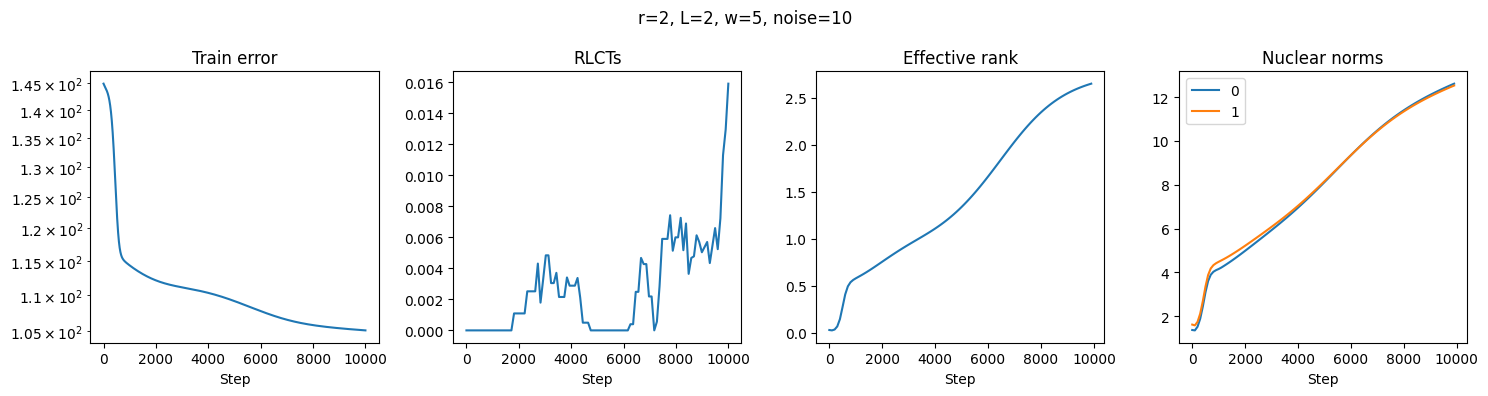

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

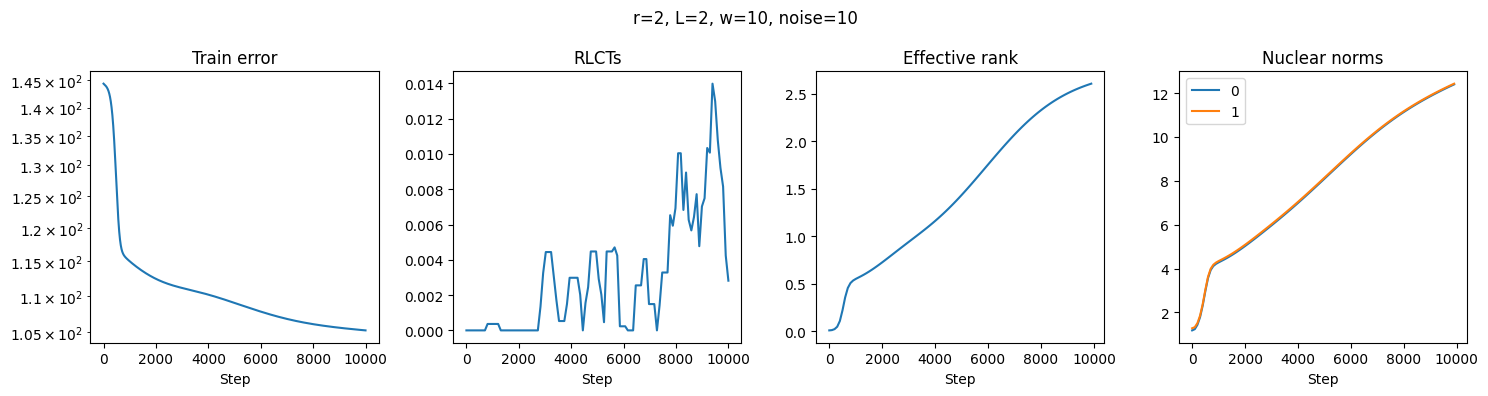

In [ ]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_err2_L2_w5 = fit(rk2_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w5, xlog=False, title="r=2, L=2, w=5, noise=10", smooth_rlcts=5)

run_rk2_err2_L2_w10 = fit(rk2_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w10, xlog=False, title="r=2, L=2, w=10, noise=10", smooth_rlcts=5)